# This notebook explores the variance in the imbalance of the Netherlands

In [67]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import seaborn as sns
import pandas as pd
from datetime import datetime
import matplotlib.ticker as ticker

sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# Load data
dl = covid19_soccer.dataloader.Dataloader_gender(countries=["NL"])

In [6]:
cases = dl._cases.xs(key="total",level="age_group") # there is only one age group
cases = cases.loc[datetime(2021,1,1):datetime(2022,1,1),:]

WARNING  [matplotlib.font_manager] findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
WARNING  [matplotlib.font_manager] findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


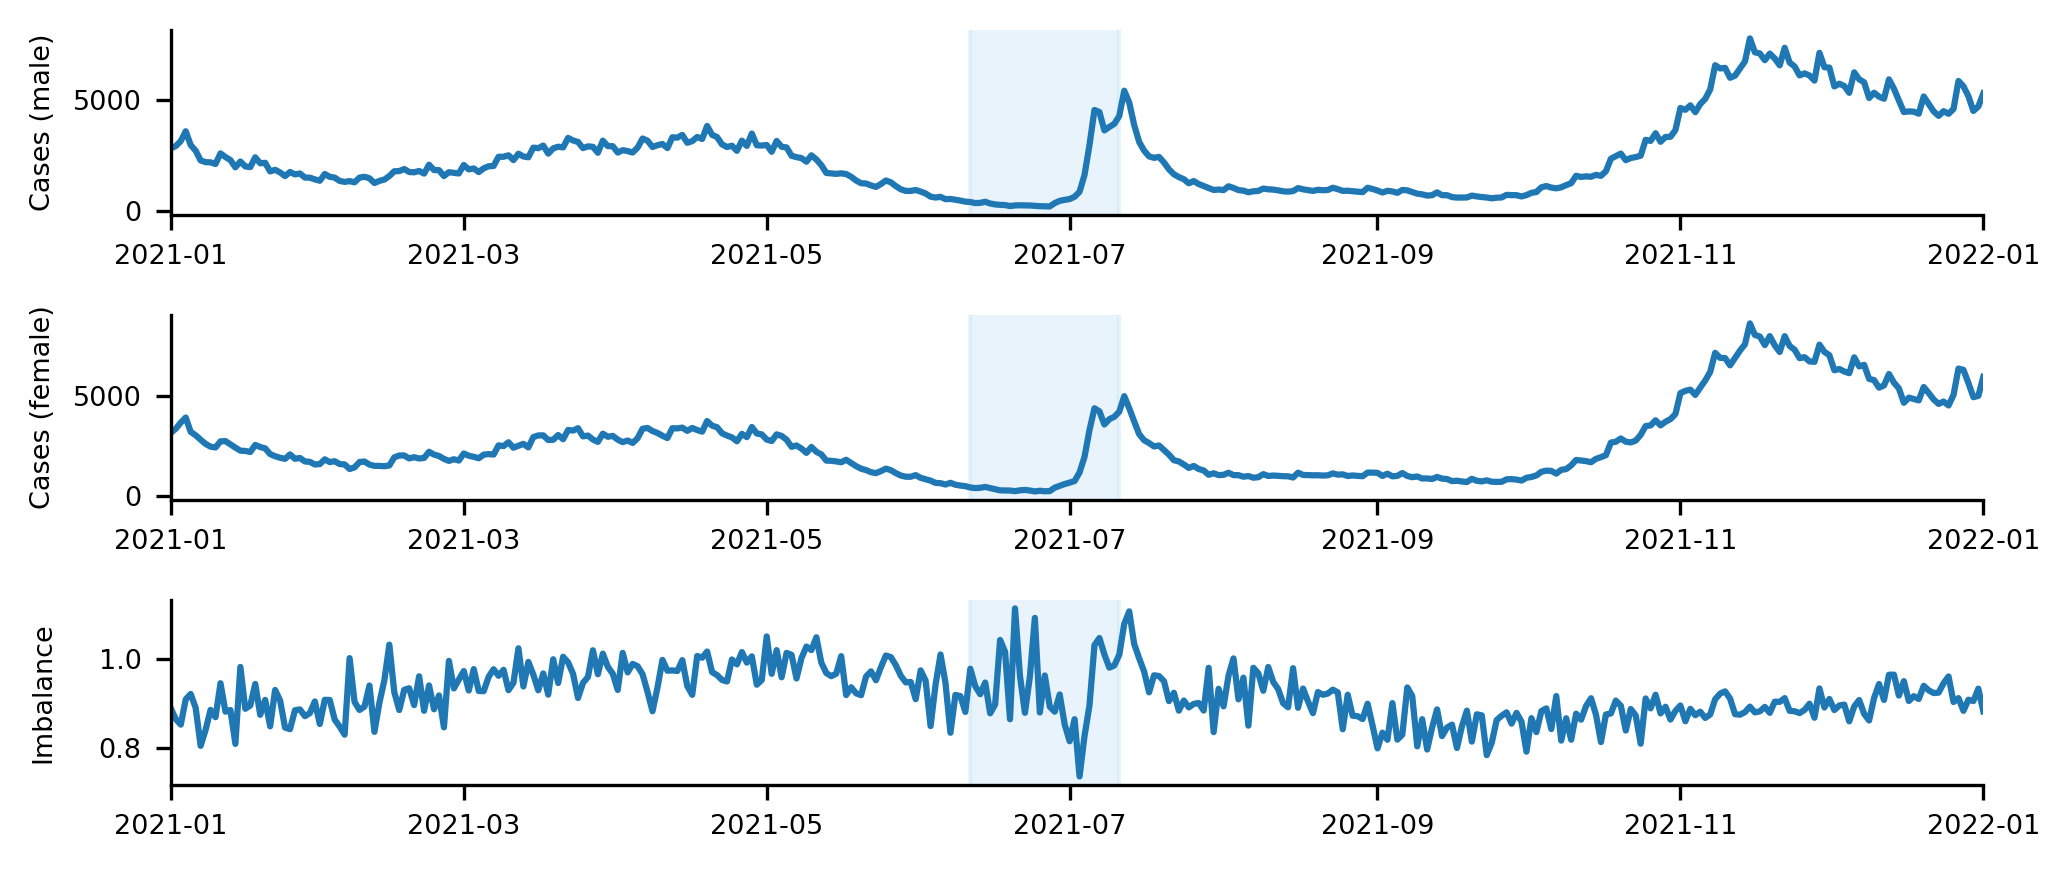

In [7]:
from covid19_soccer.plot.timeseries import _uefa_range, _format_date_xticks

# Plot gender by date
fig, axes = plt.subplots(3,1,figsize=(7,3))

male_cases = cases.xs(key="male",level="gender")
female_cases = cases.xs(key="female",level="gender")
imbalance = male_cases/female_cases

axes[0].plot(male_cases)
axes[0].set_ylabel("Cases (male)")

axes[1].plot(female_cases)
axes[1].set_ylabel("Cases (female)")

axes[2].plot(imbalance)
axes[2].set_ylabel("Imbalance")

for ax in axes:
    ax.set_xlim(datetime(2021,1,1),datetime(2022,1,1))
    #_format_date_xticks(ax)
    _uefa_range(ax)
    
fig.tight_layout()
fig.align_ylabels(axes)
    
plt.show()

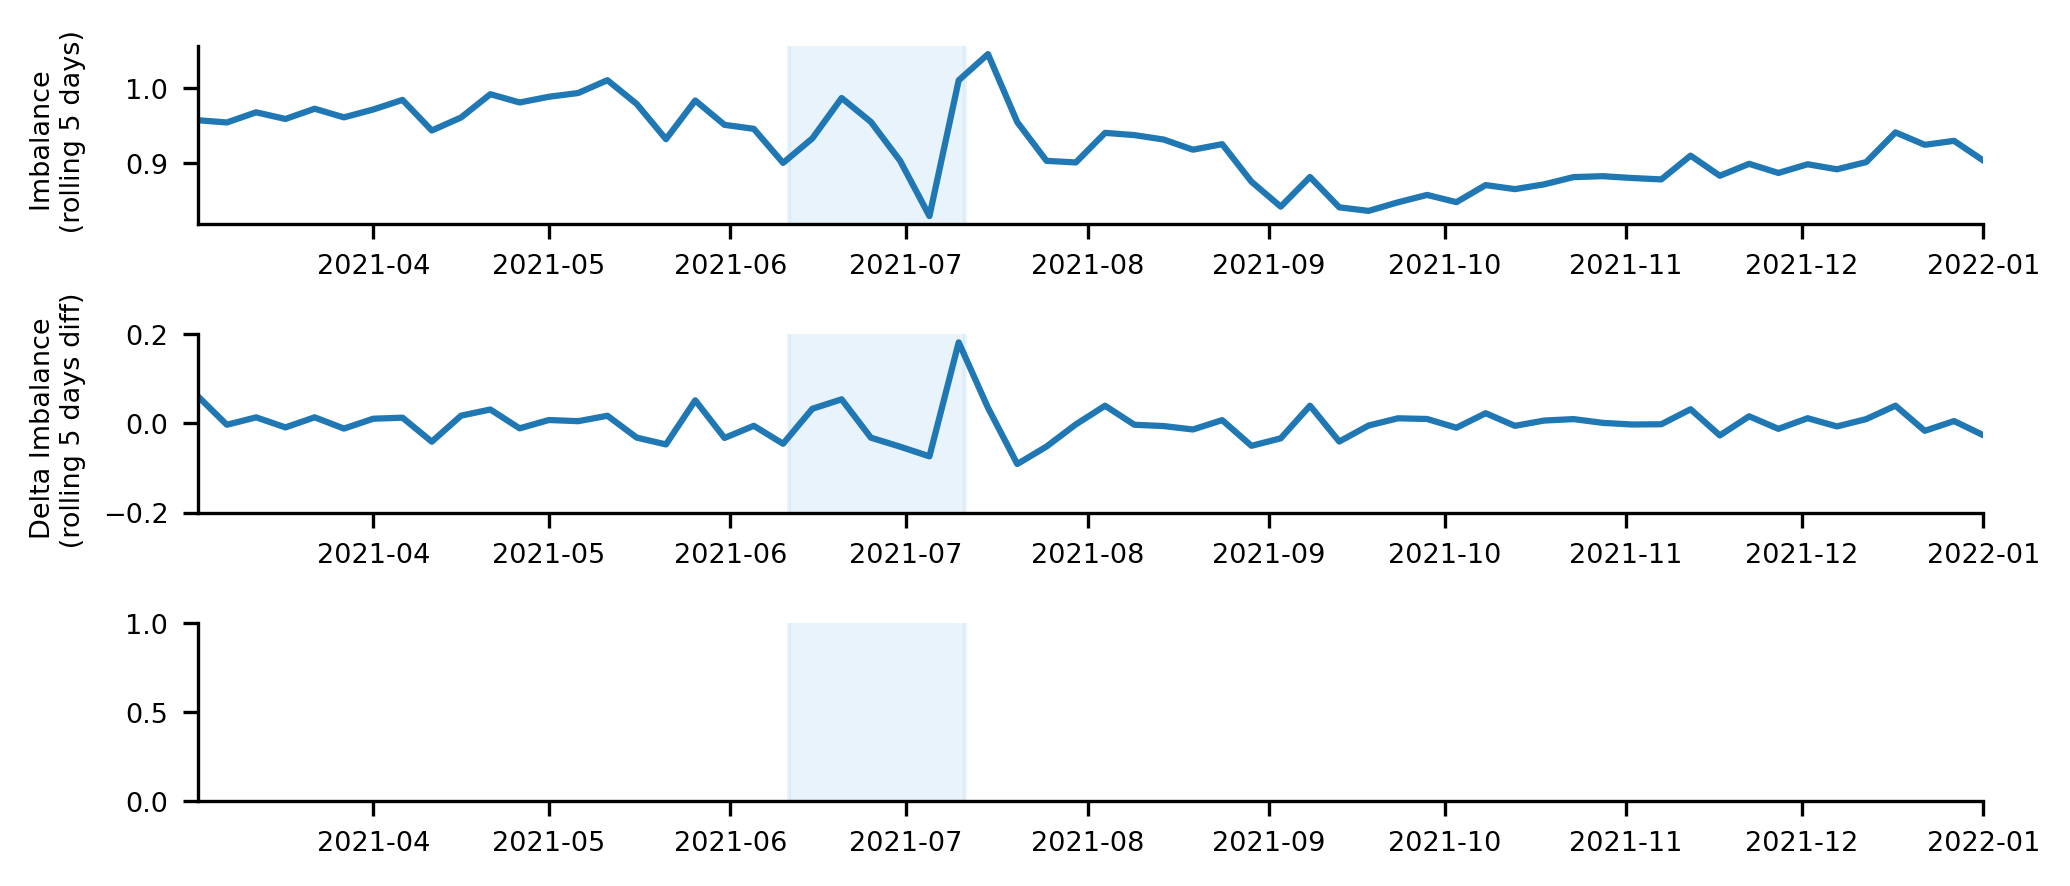

In [9]:
# Rolling average

fig, axes = plt.subplots(3,1,figsize=(7,3))

rolling_avg_imbalance = imbalance.rolling(5).mean()[::5]

axes[0].plot(rolling_avg_imbalance)
axes[0].set_ylabel("Imbalance \n (rolling 5 days)")



axes[1].plot(rolling_avg_imbalance.diff(1))
axes[1].set_ylabel("Delta Imbalance \n (rolling 5 days diff)")
axes[1].set_ylim(-0.2,0.2)

for ax in axes:
    ax.set_xlim(datetime(2021,3,2),datetime(2022,1,1))
    #_format_date_xticks(ax)
    _uefa_range(ax)

fig.tight_layout()
fig.align_ylabels(axes)
    
plt.show()

In [13]:
def load(fstr):
    return None, None
    with open(fstr, "rb") as f:
         return pickle.load(f)

countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Germany', 'Austria',
       'France', 'Slovakia', 'Belgium', 'Italy', 'Portugal',
       'Netherlands']
traces, models, dls = [], [], []
for country in tqdm(countries):
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    if country == "Spain":
        fstr=lambda tune, draws, max_treedepth: (f"/data.nst/share/soccer_project/covid_uefa_traces14_spain/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")   
    if country == "GB":
        fstr=lambda tune, draws, max_treedepth: (f"/data.nst/share/soccer_project/covid_uefa_traces15/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")   
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 2000, 12)):
        try: 
            model, trace = load(fstr(1000, 2000, 12))
            print(f"Use 2000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(500, 1000, 12)):
        try: 
            model, trace = load(fstr(500, 1000, 12))
            print(f"Use 1000 sample runs for {country}")
        except:
            pass
    if model is None: 
        print(fstr(900, 800, 99), " not found")
        # continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    # mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    # trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/12 [00:00<?, ?it/s]

Use 4000 sample runs for England
/data.nst/smohr/covid19_soccer_data/main_traces/run-beta=False-country=England-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=900-d=800-max_treedepth=99.pkl  not found
Use 4000 sample runs for Czechia
/data.nst/smohr/covid19_soccer_data/main_traces/run-beta=False-country=Czechia-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=900-d=800-max_treedepth=99.pkl  not found
Use 4000 sample runs for Scotland
/data.nst/smohr/covid19_soccer_data/main_traces/run-beta=False-country=Scotland-offset_data=0-prior_delay=-1-median_width_delay=1.0-interval_cps=10.0-f_fem=0.33-len=normal-abs_sine=False-t=900-d=800-max_treedepth=99.pkl  not found
Use 8000 sample runs for Spain
Use 4000 sample runs for Spain
Use 1000 sample runs for Spain
/data.nst/share/soccer_project/covid_uefa_traces14_spain/run-beta=False-country=Spain-offset_data=0-prior_delay=-1-m

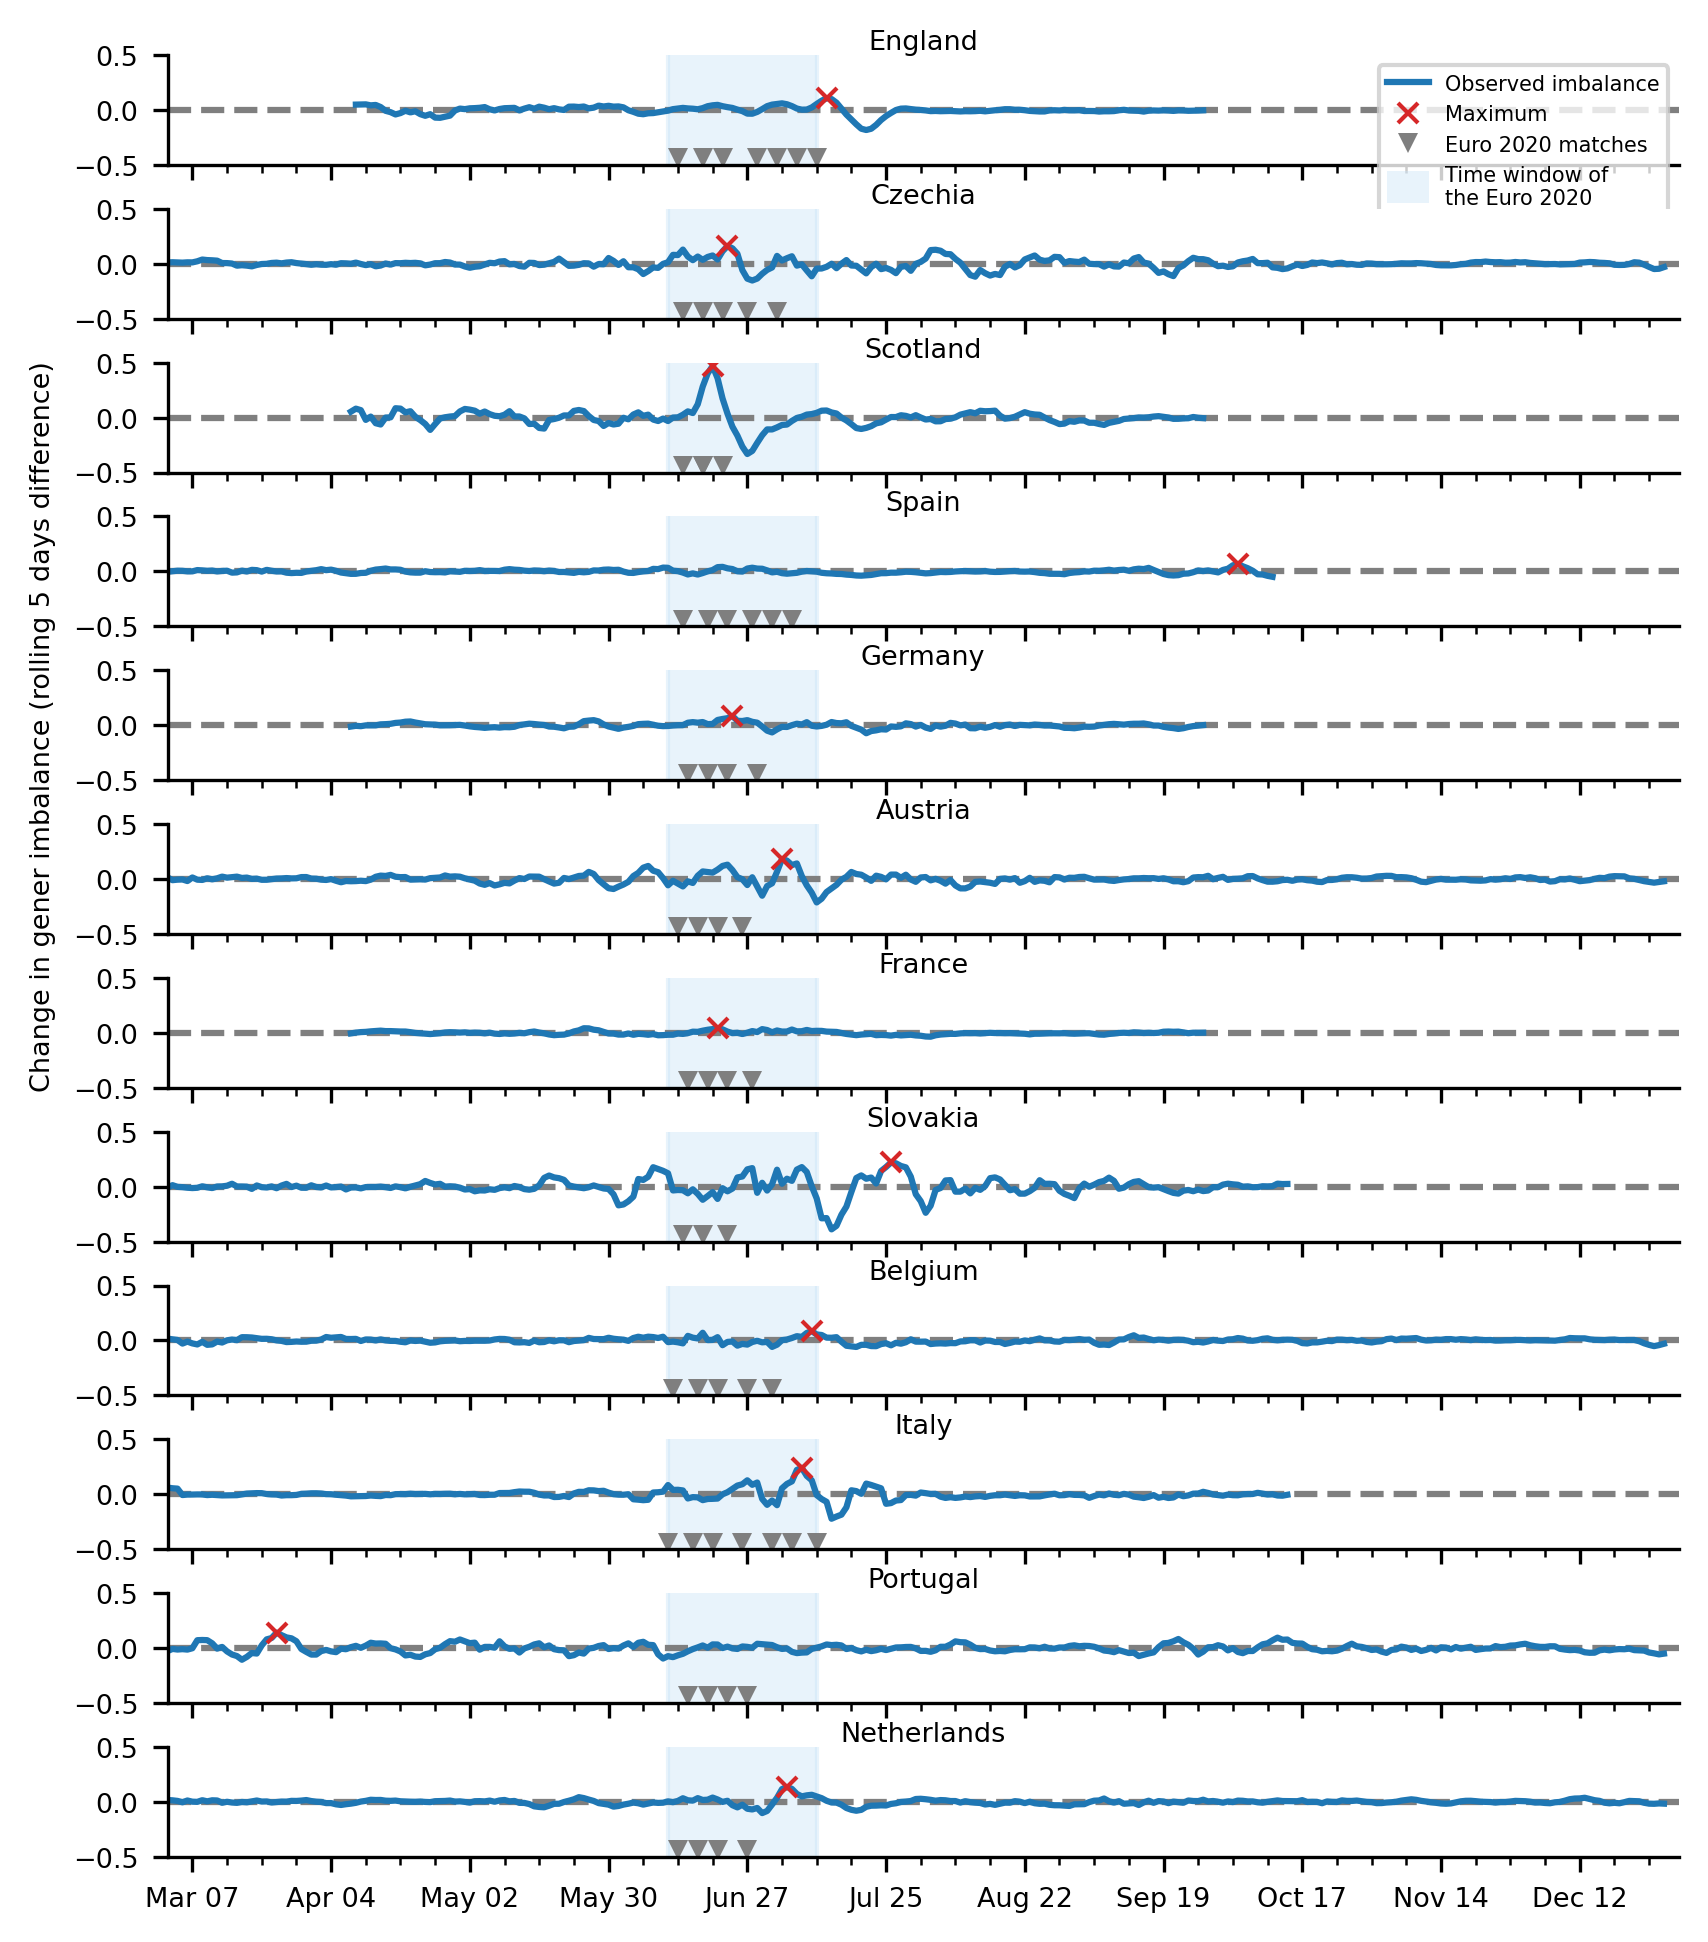

In [116]:

from scipy import ndimage as ndi
import theano.tensor as tt

def make_nice(data_obs):
    no_cases = data_obs == 0
    cases = data_obs
    if len(data_obs.shape) > 1:

        for c in range(data_obs.shape[-1]):
            cases_obs_c = data_obs[..., c]
            # find short intervals of 0 entries and set to NaN
            no_cases_blob, n_blob = ndi.label(no_cases[..., c])
            for i in range(n_blob):
                if (no_cases_blob == (i + 1)).sum() < 10:
                    data_obs[no_cases_blob == i + 1, ..., c] = np.NaN

            # shift cases from weekends or such to the next day, where cases are reported
            if n_blob > 0:
                new_cases = 0
                update = False
                for i, cases_obs in enumerate(cases_obs_c):
                    new_cases += cases[i][..., c]
                    if np.isnan(cases_obs):
                        update = True
                    elif update:
                        cases[i][..., c] = new_cases
                        new_cases = 0
                        update = False
    return cases



fig, axes = plt.subplots(len(countries),1,figsize=(6.5,0.65*len(countries)), gridspec_kw={"hspace":0.4})
for i, (country, ax) in enumerate(zip(countries, axes)):
    cases = dls[i]._cases.xs(key="total",level="age_group") # there is only one age group
    cases = cases.loc[datetime(2021,1,1):datetime(2022,1,1),:]
    if country=="Italy":
        cases.loc["2021-06-24"] = 0
    male_cases = cases.xs(key="male",level="gender").rolling(7, center=True).mean()[::]
    female_cases = cases.xs(key="female",level="gender").rolling(7, center=True).mean()[::]
    cases_nice = make_nice(np.stack((male_cases.to_numpy(), female_cases.to_numpy()), axis=1)[:,:,0])
    imbalance = (cases_nice[:, 0]+0.01)/(cases_nice[:,1]+0.01) # To avoid divisions by zero
    rolling_avg_imbalance = imbalance
    diff_imbalance = rolling_avg_imbalance[4:]-rolling_avg_imbalance[:-4]
    time = male_cases.index[4:]
    ax.plot(time, diff_imbalance)
    i_max = np.nanargmax(diff_imbalance)
    ax.plot(time[i_max], diff_imbalance[i_max], "x", color="tab:red", ms=5)
    ax.set_ylim(-0.5,0.5)
    covid19_soccer.plot.timeseries.mark_days(ax, dls[i], hosted=False)
    ax.set_xticklabels([])
    ax.set_xlim(datetime(2021,3,2),datetime(2022,1,1))
    ax.set_title(country, pad=0)
    ax.axhline(0,ls="--",color="tab:gray",zorder=-5)
    _uefa_range(ax)

axes[4].set_ylabel("Change in gener imbalance (rolling 5 days difference)")

from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from covid19_soccer.plot.other import MulticolorPatchHandler, HandlerRect, MulticolorPatch

lines = []
labels = []

# Data
lines.append(
    Line2D([0], [0], color="tab:blue")
)
labels.append("Observed imbalance")

lines.append(
    Line2D([0], [0], marker="x", color="tab:red", ms=5, lw=0)
)
labels.append("Maximum")

lines.append(Line2D([0], [0],   fillstyle="full",
            color="tab:gray",
            marker="v",
            markeredgecolor="none",
            markersize=5, lw=0))
labels.append("Euro 2020 matches")

lines.append(
    Rectangle(
        [0, 0],
        width=1,
        height=2.2,
        lw=1,
        facecolor=covid19_soccer.plot.rcParams.color_championship_range,
        edgecolor="none",
        alpha=0.4,
    )
)
labels.append("Time window of\nthe Euro 2020")





axes[0].legend(
    lines,
    labels,
    loc="upper right",
    handler_map={
        MulticolorPatch: MulticolorPatchHandler(),
        Rectangle: HandlerRect(),
    },
)


axes[-1].xaxis.set_major_formatter(mpl.dates.DateFormatter(covid19_soccer.plot.rcParams.date_format))


fig.savefig(f"../figures/SI/imbalance_overview.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/imbalance_overview.png", **save_kwargs)
#_format_date_xticks(ax)
plt.show()

In [89]:
cases_male.loc["2021-06-24"]

IT    1176.0
Name: 2021-06-24 00:00:00, dtype: float64

In [7]:
# Calc variance before/after and during championship
bg_c = datetime(2021, 6, 11)
end_c = datetime(2021, 7, 11)


mask = np.any([imbalance.index < datetime(2021, 6, 11), imbalance.index > datetime(2021, 7, 11)],axis=0)

print("Non-soccer",np.var(imbalance[mask]))
print("Soccer",np.var(imbalance[bg_c:end_c]))
print("Total",np.var(imbalance))

Non-soccer NL    0.003061
dtype: float64
Soccer NL    0.006879
dtype: float64
Total NL    0.003418
dtype: float64


In [8]:
import pymc3 as pm
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma1 = pm.Normal("sigma_1", mu=np.var(imbalance)[0], sigma=1.0)
    sigma2 = pm.Normal("sigma_2", mu=np.var(imbalance)[0], sigma=1.0)
    
    # Prior for mu
    mu = pm.Uniform("mu",0,2)
    
    nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1
    
    soccer = pm.StudentT(
        "soccer",
        nu=nu,
        mu=mu,
        sigma=sigma1,
        observed=imbalance[bg_c:end_c]
    )
    nonSoccer = pm.StudentT(
        "no-soccer",
        nu=nu,
        mu=mu,
        sigma=sigma2,
        observed=imbalance[mask]
    )
    
    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    trace = pm.sample(3000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, mu, sigma_2, sigma_1]
INFO     [pymc3] NUTS: [nu_minus_one, mu, sigma_2, sigma_1]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.
INFO     [pymc3] Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 9 seconds.


In [9]:
print(np.percentile(trace.posterior["sigma_1"],(2.5,50,97.5)))
print(np.percentile(trace.posterior["sigma_2"],(2.5,50,97.5)))


[0.06728979 0.08574373 0.11365851]
[0.04985833 0.05421558 0.05891   ]


<ipython-input-21-52d3e1da845e>:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="red", lw=0,),)
<ipython-input-21-52d3e1da845e>:13: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color="orange", lw=0,),)


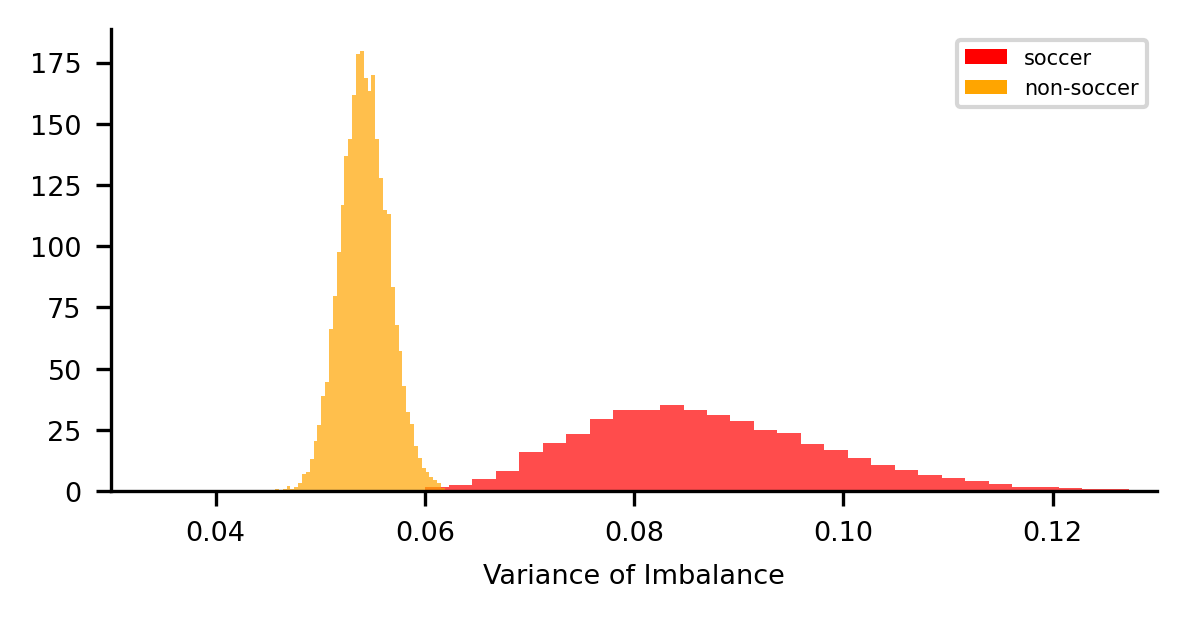

In [21]:
from matplotlib.patches import Patch
from covid19_soccer.plot.distributions import _plot_posterior

fig, ax= plt.subplots(1,1,figsize=(4.5,2))
ax.set_xlim(0.03,0.13)
_plot_posterior(trace.posterior["sigma_1"].to_numpy().flatten(),ax=ax,color="red")
_plot_posterior(trace.posterior["sigma_2"].to_numpy().flatten(),ax=ax,color="orange")

lines = []
labels = []
lines.append(Patch([0], [0], color="red", lw=0,),)
labels.append("soccer")
lines.append(Patch([0], [0], color="orange", lw=0,),)
labels.append("non-soccer")

ax.legend(lines,labels)
ax.set_xlabel("Variance of Imbalance")
plt.show()